In [1]:
import os
from random import shuffle
import pandas as pd
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.optim import lr_scheduler
from torchvision.models import resnet18, ResNet18_Weights
import torchvision.datasets as datasets
import time
import csv
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch.nn.functional as F

In [6]:
transformers = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
dataset = datasets.ImageFolder(root='/Users/demo/Desktop/COGS181_WI_24/Project/archive/data/data/train', transform=transformers)
train_loader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers= 4)

dataset_val = datasets.ImageFolder(root='/Users/demo/Desktop/COGS181_WI_24/Project/archive/data/data/val', transform=transformers)
val_loader = DataLoader(dataset_val, batch_size=256, shuffle=True, num_workers=4)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class CNN(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=16 * 112 * 112, out_features=num_classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 16 * 112 * 112)
        x = self.fc1(x)
        return x

net = CNN(num_classes=4)    
net.to(device)
loss_func = nn.CrossEntropyLoss()  
opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [4]:
avg_losses = []   # Avg. losses.
epochs = 2      # Total epochs.
print_freq = 1  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(train_loader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:     0] avg mini-batch loss: 1.418
[epoch: 0, i:     1] avg mini-batch loss: 1.812
[epoch: 0, i:     2] avg mini-batch loss: 3.283
[epoch: 0, i:     3] avg mini-batch loss: 2.440
[epoch: 0, i:     4] avg mini-batch loss: 5.573
[epoch: 0, i:     5] avg mini-batch loss: 5.655
[epoch: 0, i:     6] avg mini-batch loss: 4.947
[epoch: 0, i:     7] avg mini-batch loss: 5.698
[epoch: 0, i:     8] avg mini-batch loss: 3.317
[epoch: 0, i:     9] avg mini-batch loss: 5.359
[epoch: 0, i:    10] avg mini-batch loss: 4.985
[epoch: 0, i:    11] avg mini-batch loss: 3.101
[epoch: 0, i:    12] avg mini-batch loss: 2.925
[epoch: 0, i:    13] avg mini-batch loss: 3.264
[epoch: 0, i:    14] avg mini-batch loss: 3.868
[epoch: 0, i:    15] avg mini-batch loss: 2.945
[epoch: 0, i:    16] avg mini-batch loss: 2.259
[epoch: 0, i:    17] avg mini-batch loss: 2.173
[epoch: 0, i:    18] avg mini-batch loss: 2.915
[epoch: 0, i:    19] avg mini-batch loss: 3.411
[epoch: 0, i:    20] avg mini-batch loss

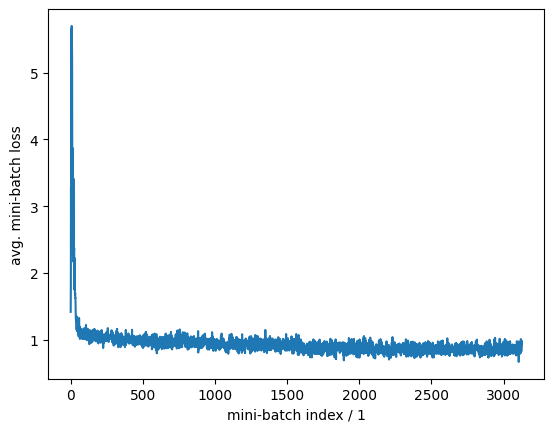

In [5]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

In [7]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 val images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 65 %
